In [ ]:
# Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import missingno as msno

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Save & Load
import joblib
import os

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load dataset
df = pd.read_csv("fake_job_postings.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [5]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


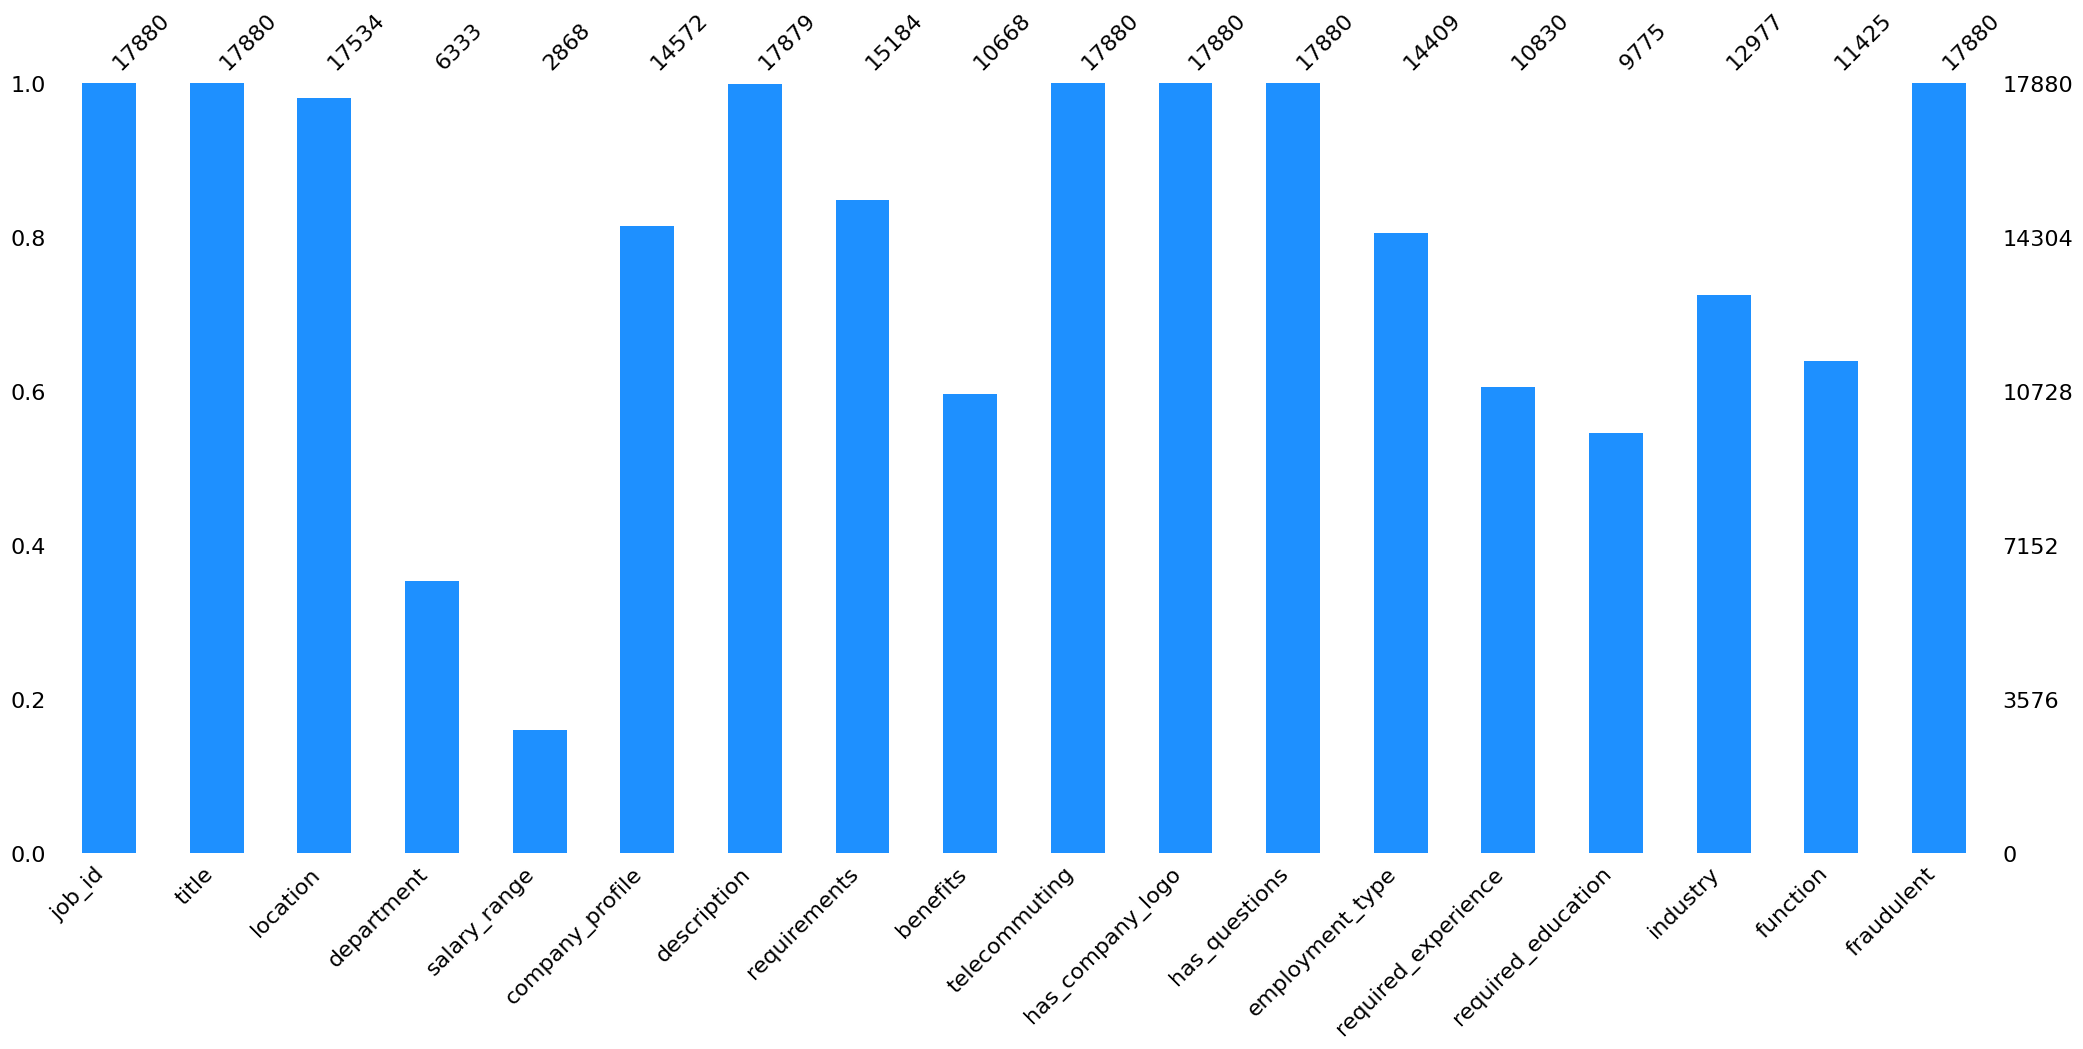

<Figure size 1000x500 with 0 Axes>

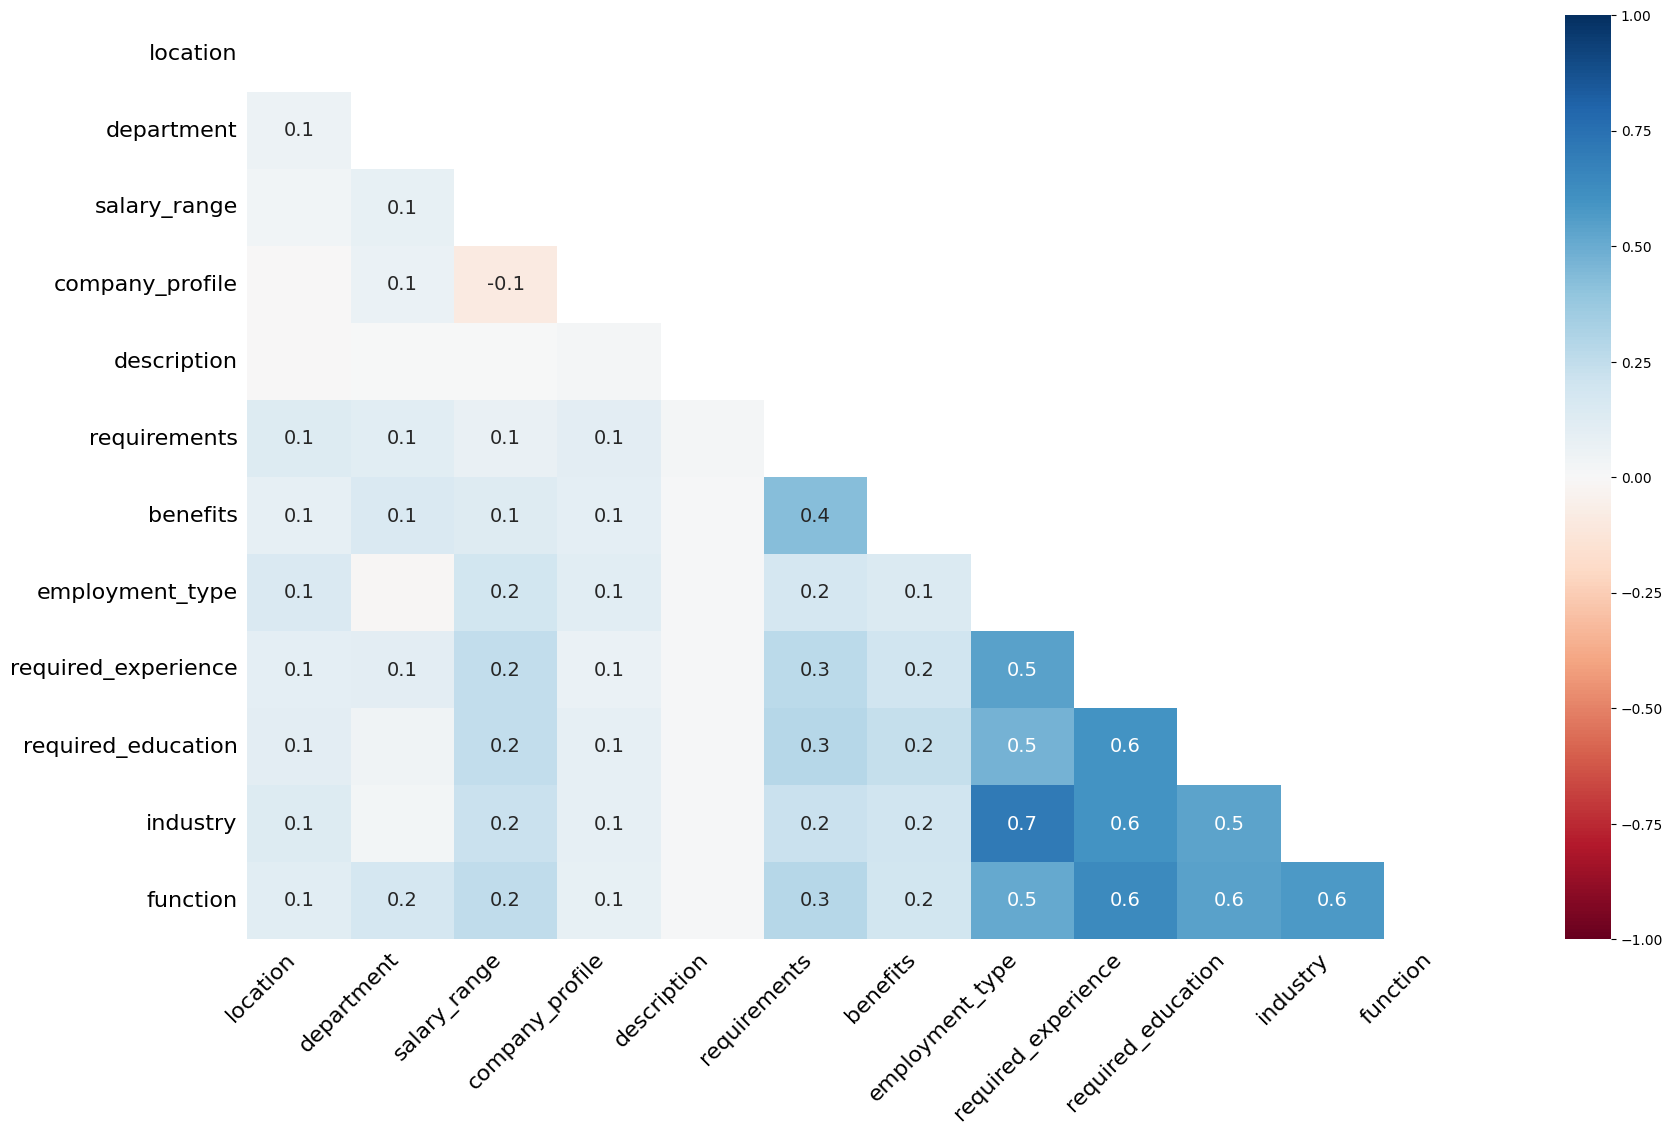

In [8]:
# Visualize Missing Data
plt.figure(figsize=(10,5))
msno.bar(df, color="dodgerblue")
plt.show()

plt.figure(figsize=(10,5))
msno.heatmap(df)
plt.show()

In [9]:
# Handle missing values
print("Percentage of missing values:")
print((df.isnull().sum() / len(df) * 100).round(2))

Percentage of missing values:
job_id                  0.00
title                   0.00
location                1.94
department             64.58
salary_range           83.96
company_profile        18.50
description             0.01
requirements           15.08
benefits               40.34
telecommuting           0.00
has_company_logo        0.00
has_questions           0.00
employment_type        19.41
required_experience    39.43
required_education     45.33
industry               27.42
function               36.10
fraudulent              0.00
dtype: float64


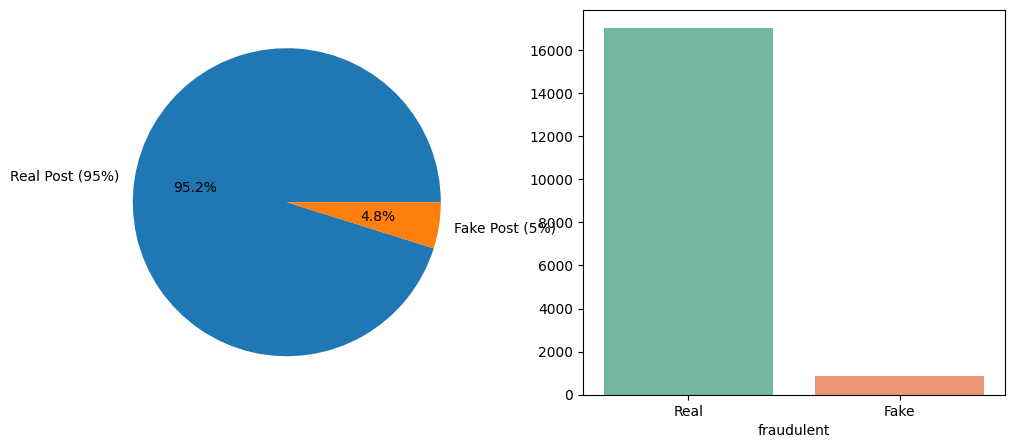

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
df["fraudulent"].value_counts().plot(
    kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fake Post (5%)'], autopct='%1.1f%%'
)

# Corrected barplot
temp = df["fraudulent"].value_counts()
sns.barplot(x=temp.index, y=temp.values, ax=axes[1], palette="Set2")

# Clean labels
axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(['Real', 'Fake'])

plt.show()

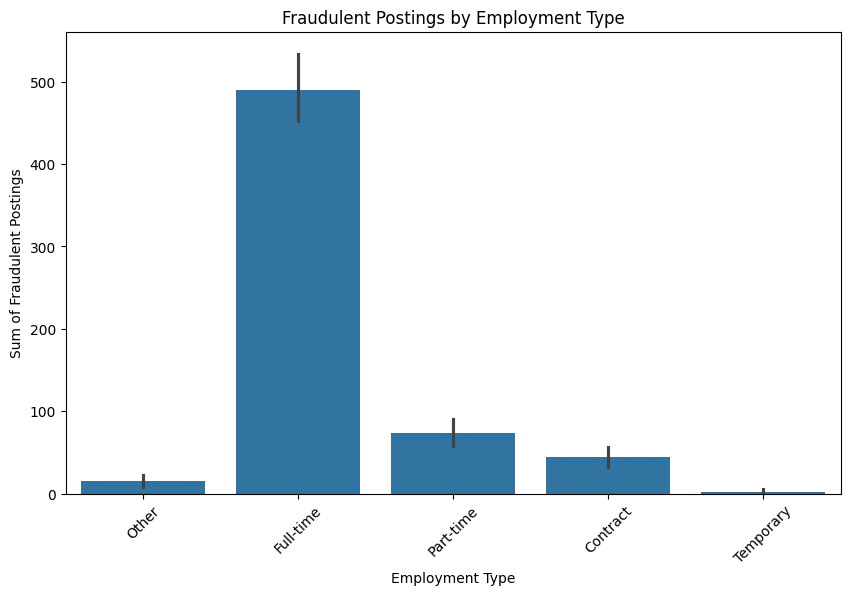

In [11]:
# Bar plot for employment_type
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='employment_type', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

In [13]:
import re
from bs4 import BeautifulSoup

def simple_clean(text):
    if pd.isna(text): 
        return ""
    text = BeautifulSoup(str(text), "lxml").get_text()   # remove HTML
    text = re.sub(r"http\S+|www\S+", "", text)           # remove links
    text = re.sub(r"[^a-zA-Z]", " ", text)               # keep letters only
    text = text.lower()
    return text

# Create cleaned column
df['description_clean'] = df['description'].apply(simple_clean)


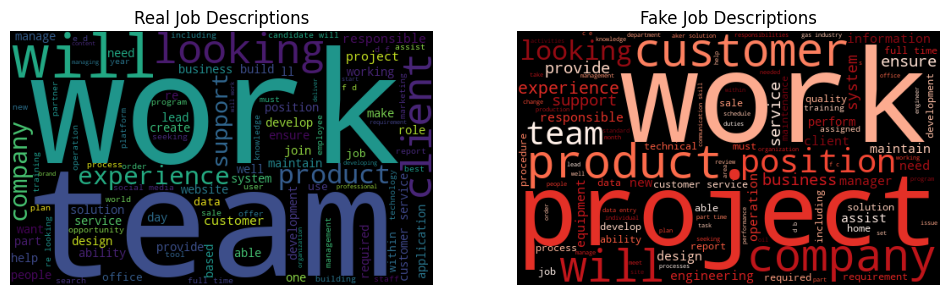

In [14]:
from wordcloud import WordCloud

real_text = " ".join(df[df['fraudulent']==0]['description_clean'])
fake_text = " ".join(df[df['fraudulent']==1]['description_clean'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=500,height=300,max_words=100).generate(real_text))
plt.axis("off")
plt.title("Real Job Descriptions")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=500,height=300,max_words=100,colormap="Reds").generate(fake_text))
plt.axis("off")
plt.title("Fake Job Descriptions")

plt.show()

In [15]:
print("\nFraudulent ratio:", df["fraudulent"].mean())
print("\nTop Job Titles:")
print(df["title"].value_counts().head())


Fraudulent ratio: 0.04843400447427293

Top Job Titles:
title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
Name: count, dtype: int64


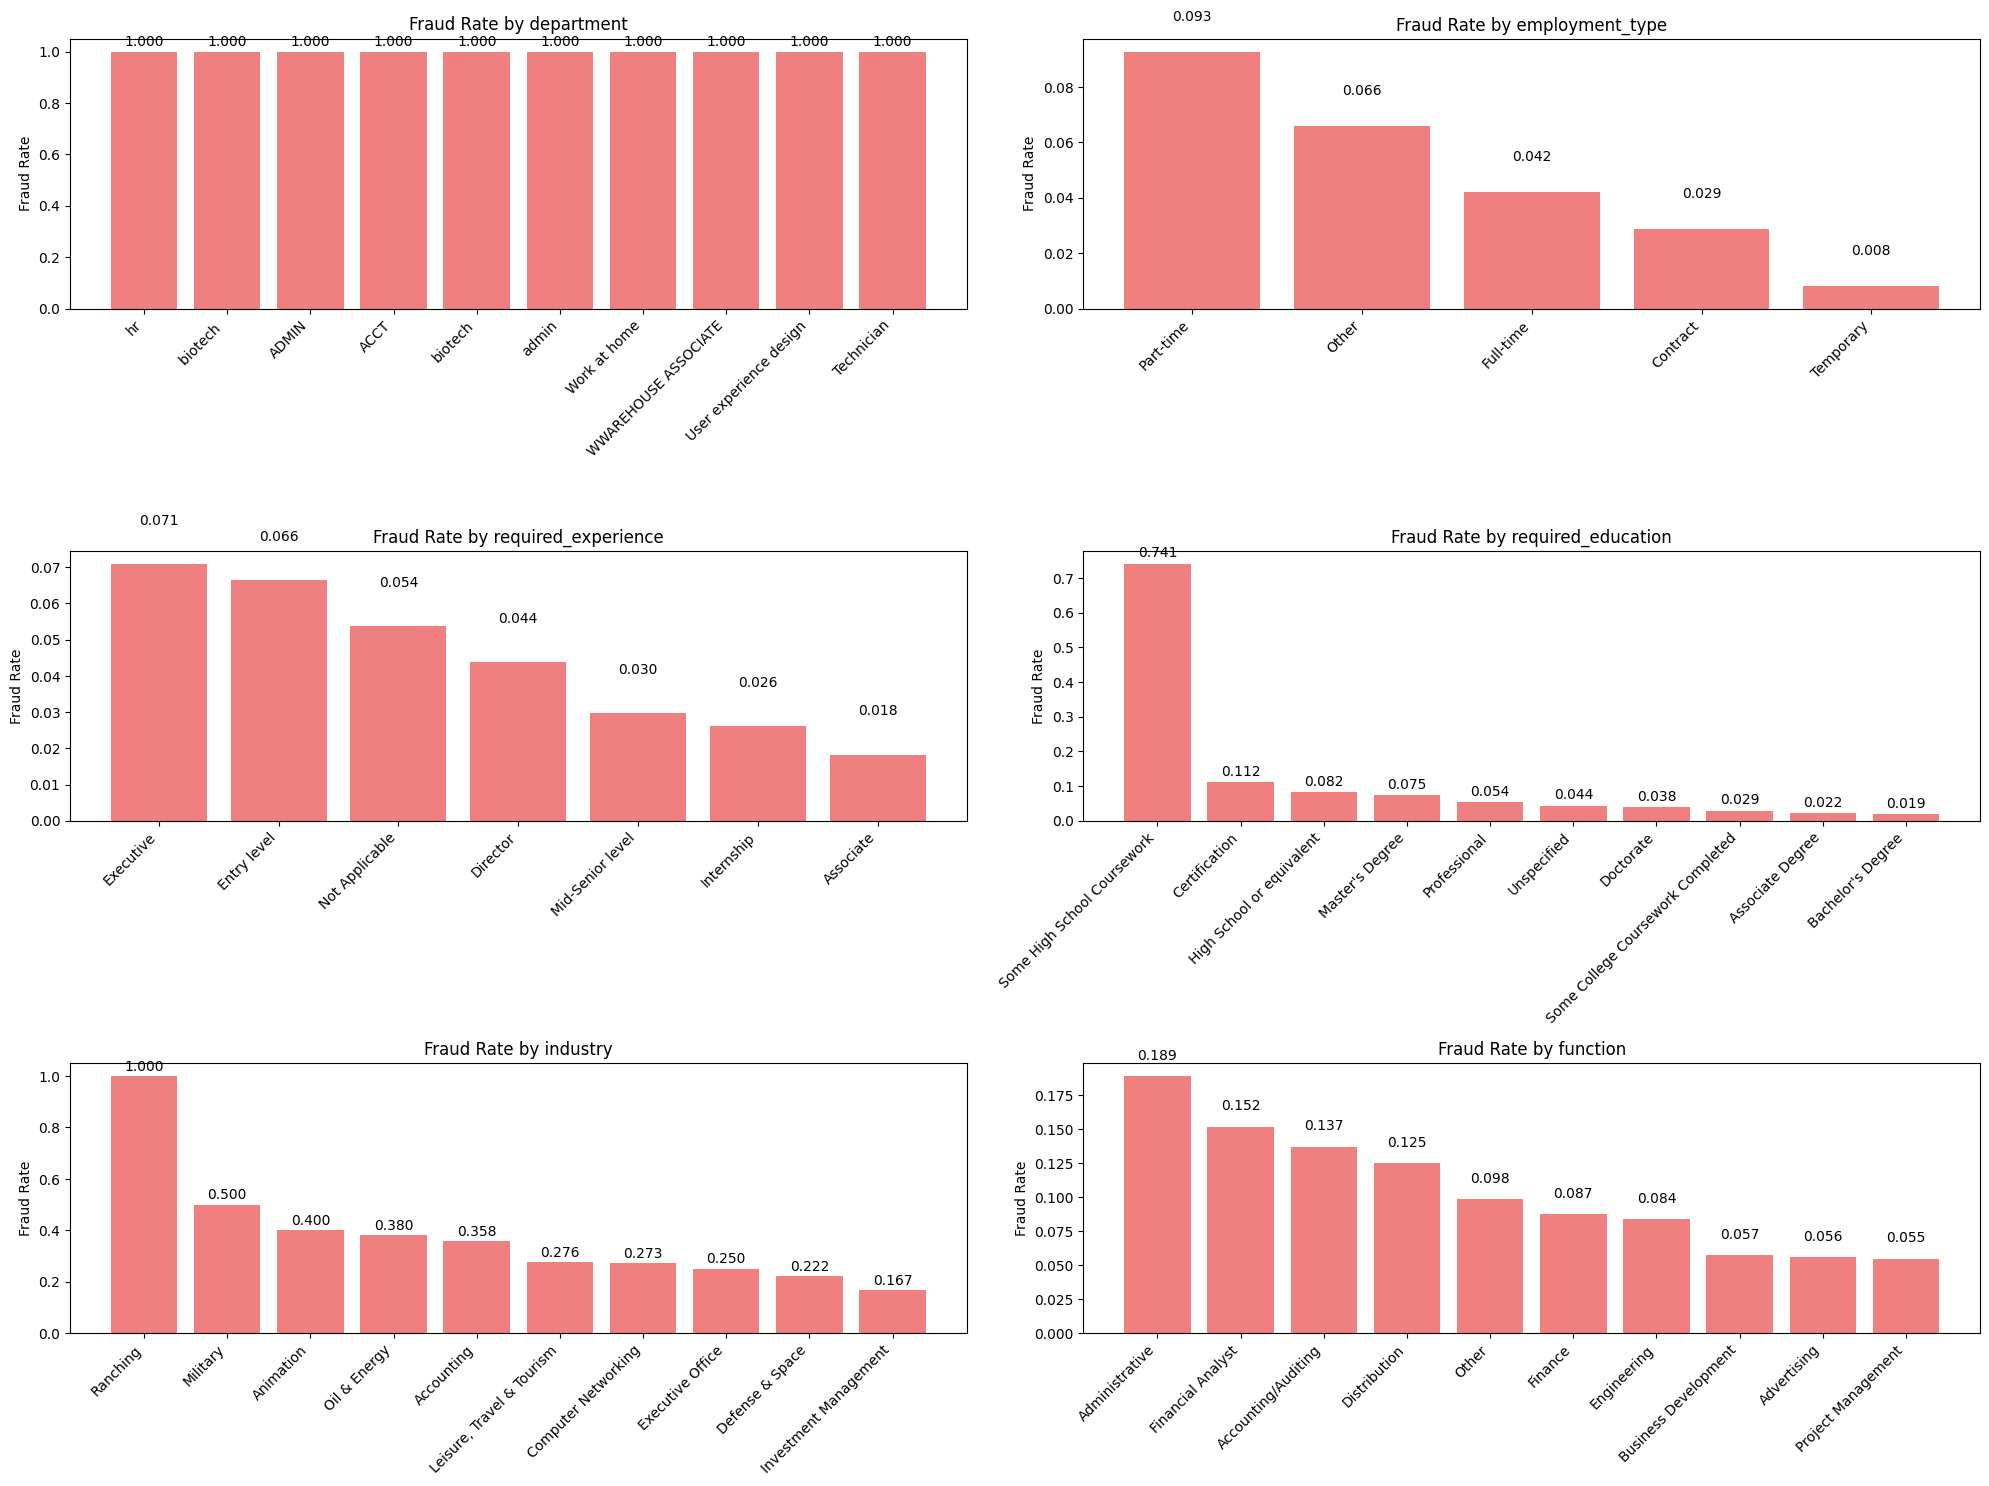

In [16]:
def analyze_categorical_features(df, target='fraudulent'):
    cat_cols = ['department', 'employment_type', 'required_experience', 
                'required_education', 'industry', 'function']
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, col in enumerate(cat_cols):
        # Calculate fraud rate by category
        fraud_rates = df.groupby(col)[target].mean().sort_values(ascending=False)
        
        # Plot top 10 categories by fraud rate
        top_categories = fraud_rates.head(10)
        axes[i].bar(range(len(top_categories)), top_categories.values, color='lightcoral')
        axes[i].set_xticks(range(len(top_categories)))
        axes[i].set_xticklabels(top_categories.index, rotation=45, ha='right')
        axes[i].set_title(f'Fraud Rate by {col}')
        axes[i].set_ylabel('Fraud Rate')
        
        # Add value annotations
        for j, v in enumerate(top_categories.values):
            axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

analyze_categorical_features(df)

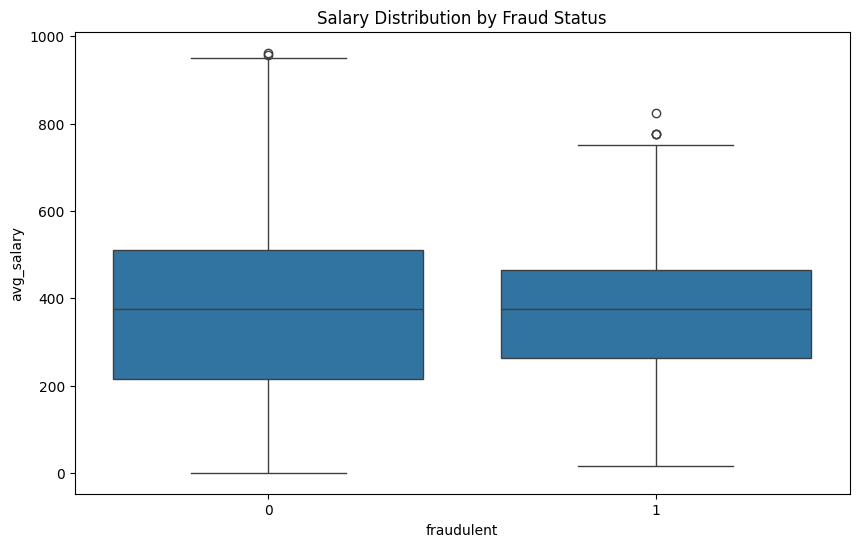

In [17]:
# Salary extraction and analysis
def extract_salary(s):
    if pd.isna(s) or s == 'Not specified': return np.nan
    amounts = re.findall(r'\$?(\d{1,3}(?:,\d{3})*)', str(s))
    amounts = [float(a.replace(',', '')) for a in amounts if float(a.replace(',', '')) > 0]
    return np.mean(amounts) if amounts else np.nan

df['avg_salary'] = df['salary_range'].apply(extract_salary)

# Salary vs fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='fraudulent', y='avg_salary', data=df[df['avg_salary'].notna()])
plt.title('Salary Distribution by Fraud Status')
plt.show()

In [3]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

# Handle Missing Values

In [4]:
class dfmissing_values:
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def fill_missing_values(self):
        # Salary
        if 'salary_range' in self.df.columns:
            self.df['salary_range'].fillna('Not specified', inplace=True)
        # Categorical
        categorical_cols = [
            'location', 'department', 'employment_type',
            'required_experience', 'required_education',
            'industry', 'function'
        ]
        for col in categorical_cols:
            if col in self.df.columns:
                self.df[col].fillna('Unknown', inplace=True)
        # Text columns
        text_cols = ['company_profile', 'description', 'requirements', 'benefits']
        for col in text_cols:
            if col in self.df.columns:
                self.df[col].fillna('', inplace=True)
        return self.df

# Apply missing value handling
missing_handler = dfmissing_values(df)
df = missing_handler.fill_missing_values()

# Categorical Encoding

In [5]:
class CategoricalEncoder:
    def __init__(self, target: str = None):
        self.target = target
        self.encoding_plan = {}
        self.freq_maps = {}
        self.target_maps = {}

    def fit_transform(self, df: pd.DataFrame):
        df_encoded = df.copy()
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

        for col in categorical_cols:
            unique_count = df[col].nunique()
            if unique_count <= 5:
                encoded = pd.get_dummies(df[col], prefix=col, drop_first=True)
                df_encoded = pd.concat([df_encoded, encoded], axis=1)
                df_encoded.drop(col, axis=1, inplace=True)
                self.encoding_plan[col] = f'onehot_{unique_count}_categories'
            elif unique_count <= 20:
                if self.target and self.target in df.columns:
                    global_mean = df[self.target].mean()
                    category_means = df.groupby(col)[self.target].mean()
                    category_counts = df.groupby(col)[self.target].count()
                    smoothed_means = (category_counts * category_means + 10 * global_mean) / (category_counts + 10)
                    df_encoded[col] = df[col].map(smoothed_means)
                    self.target_maps[col] = smoothed_means
                    self.encoding_plan[col] = 'target_encoding'
                else:
                    freq = df[col].value_counts(normalize=True)
                    df_encoded[col] = df[col].map(freq)
                    self.freq_maps[col] = freq
                    self.encoding_plan[col] = 'frequency_encoding'
            else:
                freq = df[col].value_counts(normalize=True)
                df_encoded[col] = df[col].map(freq)
                self.freq_maps[col] = freq
                self.encoding_plan[col] = 'frequency_encoding'
        return df_encoded

# Apply categorical encoding
encoder = CategoricalEncoder(target='fraudulent')
df = encoder.fit_transform(df)

# Feature Scaling

In [6]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [7]:
df['fraudulent'] = df['fraudulent'].astype(int)

In [8]:
# Map any non-zero value to 1
df['fraudulent'] = df['fraudulent'].apply(lambda x: 1 if x != 0 else 0)

# Ensure integer type
df['fraudulent'] = df['fraudulent'].astype(int)

# Check
print(df['fraudulent'].value_counts())


fraudulent
0    17014
1      866
Name: count, dtype: int64


# Train/Test Split

In [29]:
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [30]:
# -------------------------------
# 6️⃣ Initial 4 ML Models & Scores
# -------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

initial_scores = {}
for name, model in models.items():
    print(f"\n📌 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    initial_scores[name] = acc
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    joblib.dump(model, f"models/{name.replace(' ', '_')}_initial.pkl")

# Save initial scores
joblib.dump(initial_scores, "models/initial_scores.pkl")
print("\n✅ All initial models trained and scores saved!")


📌 Training Logistic Regression...
Accuracy: 0.9600
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3403
           1       0.89      0.20      0.32       173

    accuracy                           0.96      3576
   macro avg       0.93      0.60      0.65      3576
weighted avg       0.96      0.96      0.95      3576


📌 Training Random Forest...
Accuracy: 0.9782
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.93      0.60      0.73       173

    accuracy                           0.98      3576
   macro avg       0.95      0.80      0.86      3576
weighted avg       0.98      0.98      0.98      3576


📌 Training XGBoost...


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:company_profile: object

| Model               | Accuracy | Precision (class 1) | Recall (class 1) | F1-score (class 1) |
| ------------------- | -------- | ------------------- | ---------------- | ------------------ |
| Logistic Regression | 0.9553   | 0.84                | 0.09             | 0.17               |
| Random Forest       | 0.9849   | 0.99                | 0.69             | 0.82               |
| XGBoost             | 0.9852   | 0.98                | 0.71             | 0.82               |
| LightGBM            | 0.9863   | 0.98                | 0.73             | 0.84               |


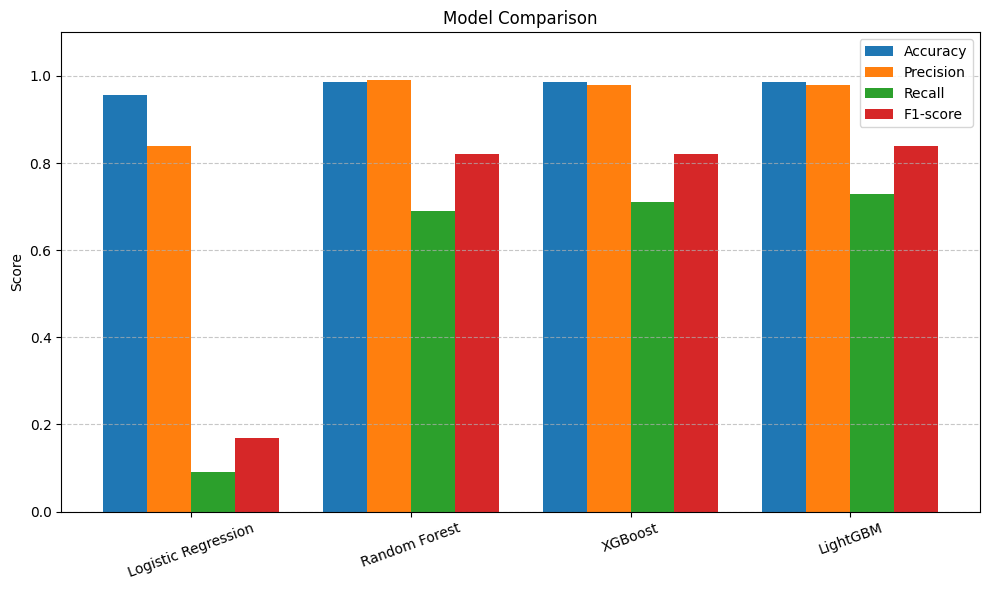

In [ ]:
# Drop job_id
df = df.drop('job_id', axis=1)


In [ ]:
# -------------------------------
# Text-based features: lengths and word counts
# -------------------------------
df['title_len'] = df['title'].apply(lambda x: len(str(x)))
df['description_len'] = df['description'].apply(lambda x: len(str(x)))
df['requirements_len'] = df['requirements'].apply(lambda x: len(str(x)))
df['benefits_len'] = df['benefits'].apply(lambda x: len(str(x)))

df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))
df['description_word_count'] = df['description'].apply(lambda x: len(str(x).split()))
df['requirements_word_count'] = df['requirements'].apply(lambda x: len(str(x).split()))
df['benefits_word_count'] = df['benefits'].apply(lambda x: len(str(x).split()))

In [ ]:
# Import TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for col in text_cols:
    df[col] = df[col].fillna("").astype(str)


# Now you can use it
tfidf = TfidfVectorizer(max_features=100)
title_tfidf = tfidf.fit_transform(df['title']).toarray()
title_tfidf_df = pd.DataFrame(title_tfidf, columns=[f"title_tfidf_{i}" for i in range(title_tfidf.shape[1])])

# TF-IDF vectorization (for 'title')
# -------------------------------
tfidf = TfidfVectorizer(max_features=100)
title_tfidf = tfidf.fit_transform(df['title']).toarray()
title_tfidf_df = pd.DataFrame(title_tfidf, columns=[f"title_tfidf_{i}" for i in range(title_tfidf.shape[1])])
df = pd.concat([df.reset_index(drop=True), title_tfidf_df], axis=1)

# Drop original text columns if not using for modeling
df = df.drop(['title', 'description', 'requirements', 'benefits'], axis=1)

In [ ]:
# -------------------------------
# Split X, y
# -------------------------------
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Handle class imbalance with SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
# Scale features
# -------------------------------
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression Grid Search
# -------------------------------
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2']
}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_param_grid, cv=5, scoring='f1')
lr_grid.fit(X_train_res, y_train_res)
lr_best = lr_grid.best_estimator_
print("Best LR params:", lr_grid.best_params_)

Best LR params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
# Random Forest Grid Search
# -------------------------------
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='f1')
rf_grid.fit(X_train_res, y_train_res)
rf_best = rf_grid.best_estimator_
print("Best RF params:", rf_grid.best_params_)

Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# XGBoost Grid Search
# -------------------------------
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1]
}
xgb_grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                        xgb_param_grid, cv=3, scoring='f1')
xgb_grid.fit(X_train_res, y_train_res)
xgb_best = xgb_grid.best_estimator_
print("Best XGB params:", xgb_grid.best_params_)

Best XGB params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}


In [ ]:
# LightGBM Grid Search
# -------------------------------
lgb_param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}
lgb_grid = GridSearchCV(lgb.LGBMClassifier(random_state=42), lgb_param_grid, cv=3, scoring='f1')
lgb_grid.fit(X_train_res, y_train_res)
lgb_best = lgb_grid.best_estimator_
print("Best LGB params:", lgb_grid.best_params_)

[LightGBM] [Info] Number of positive: 9074, number of negative: 9074
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4027
[LightGBM] [Info] Number of data points in the train set: 18148, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9074, number of negative: 9074
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 18148, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

models = {
    "Logistic Regression": lr_best,
    "Random Forest": rf_best,
    "XGBoost": xgb_best,
    "LightGBM": lgb_best
}

initial_scores = {}

for name, model in models.items():
    print(f"\n📌 Training {name}...")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", round(acc, 4))
    print(classification_report(y_test, y_pred))
    initial_scores[name] = acc

print("\n✅ All models trained with tuned hyperparameters and scores saved!")



📌 Training Logistic Regression...
Accuracy: 0.8238
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      3403
           1       0.18      0.75      0.29       173

    accuracy                           0.82      3576
   macro avg       0.58      0.79      0.60      3576
weighted avg       0.95      0.82      0.87      3576


📌 Training Random Forest...
Accuracy: 0.9771
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3403
           1       0.81      0.68      0.74       173

    accuracy                           0.98      3576
   macro avg       0.90      0.84      0.87      3576
weighted avg       0.98      0.98      0.98      3576


📌 Training XGBoost...
Accuracy: 0.9659
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3403
           1       0.63      0.70      0.66       173

    accuracy                           0.97 

In [ ]:
# Dictionary of models to save
models_to_save = {
    "Logistic_Regression": lr_best,
    "Random_Forest": rf_best,
    "XGBoost": xgb_best,
    "LightGBM": lgb_best
}

# Save each model as a separate .pkl file
for name, model in models_to_save.items():
    filename = f"{name}.pkl"
    joblib.dump(model, filename)
    print(f"✅ {name} saved as {filename}")

✅ Logistic_Regression saved as Logistic_Regression.pkl
✅ Random_Forest saved as Random_Forest.pkl
✅ XGBoost saved as XGBoost.pkl
✅ LightGBM saved as LightGBM.pkl


In [ ]:
results = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM"],
    "Accuracy": [0.8238, 0.9771, 0.9659, 0.9765],
    "Precision (Class 1)": [0.18, 0.81, 0.63, 0.78],
    "Recall (Class 1)": [0.75, 0.68, 0.70, 0.72],
    "F1-score (Class 1)": [0.29, 0.74, 0.66, 0.75]
}

df_results = pd.DataFrame(results)
df_results

,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1)
0,Logistic Regression,0.8238,0.18,0.75,0.29
1,Random Forest,0.9771,0.81,0.68,0.74
2,XGBoost,0.9659,0.63,0.70,0.66
3,LightGBM,0.9765,0.78,0.72,0.75


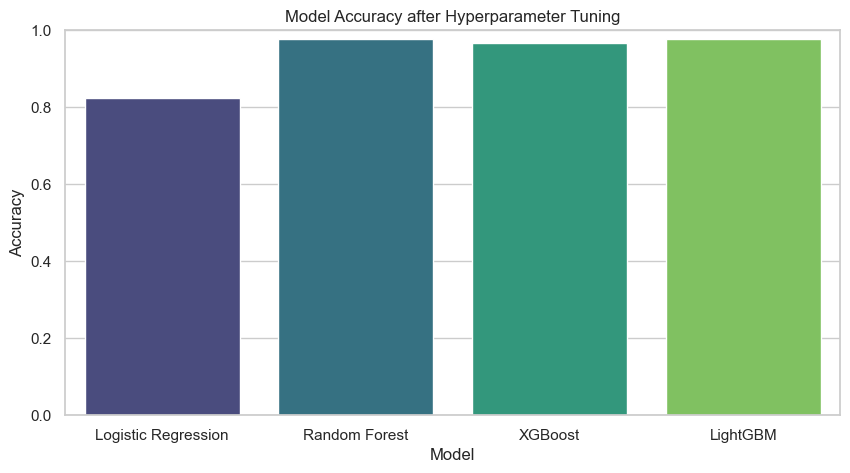

# Comparision Before Tuning & After Tuning

| Model               | Accuracy (before) | Precision (class 1, before) | Recall (class 1, before) | F1-score (class 1, before) | Accuracy (after) | Precision (class 1, after) | Recall (class 1, after) | F1-score (class 1, after) |
| ------------------- | ----------------- | --------------------------- | ------------------------ | -------------------------- | ---------------- | -------------------------- | ----------------------- | ------------------------- |
| Logistic Regression | 0.9553            | 0.84                        | 0.09                     | 0.17                       | 0.8238           | 0.18                       | 0.75                    | 0.29                      |
| Random Forest       | 0.9849            | 0.99                        | 0.69                     | 0.82                       | 0.9771           | 0.81                       | 0.68                    | 0.74                      |
| XGBoost             | 0.9852            | 0.98                        | 0.71                     | 0.82                       | 0.9659           | 0.63                       | 0.70                    | 0.66                      |
| LightGBM            | 0.9863            | 0.98                        | 0.73                     | 0.84                       | 0.9765           | 0.78                       | 0.72                    | 0.75                      |


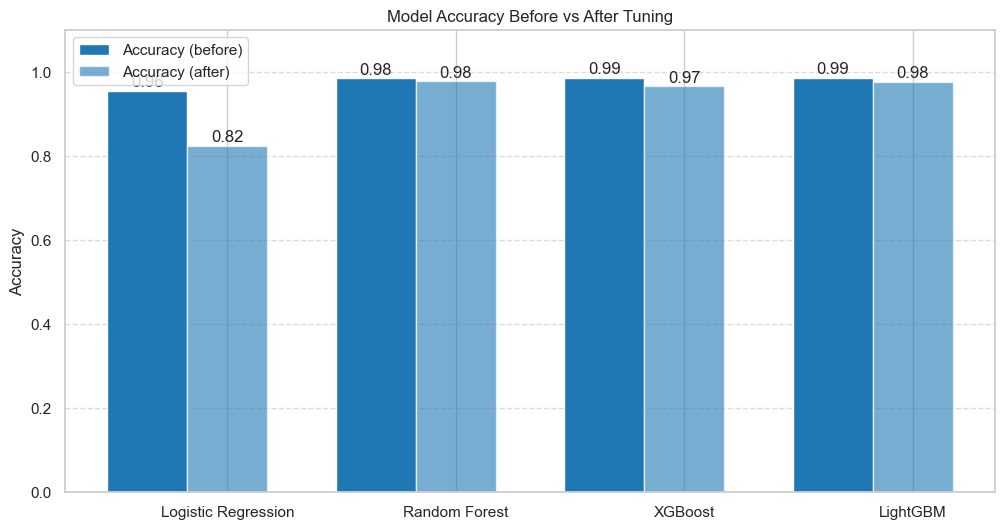